# Using other networks

In `JaxILI`, you can use different neural networks to train your generative model. In this notebook, we show on the "Getting started" example how this can be done.

In [4]:
import os

import jax
import jax.numpy as jnp

from jaxili.inference import NPE
from jaxili.model import ConditionalRealNVP

print("Device used by jax:", jax.devices())

Device used by jax: [CudaDevice(id=0)]


In [2]:
n_dim = 3

def simulator(theta, rng_key):
    batch_size = theta.shape[0]
    return theta + jax.random.normal(rng_key, shape=(batch_size, n_dim))*0.1

## Creating the dataset

In [5]:
master_key = jax.random.PRNGKey(0)
num_samples = 10_000

theta_key, master_key = jax.random.split(master_key)

theta = jax.random.uniform(theta_key, shape=(num_samples, n_dim), minval=-2.*jnp.ones((n_dim)), maxval=3.*jnp.ones((n_dim)))

sim_key, master_key = jax.random.split(master_key)
x = simulator(theta, sim_key)

In [6]:
print("Parameters shape:", theta.shape)
print("Data shape:", x.shape)

Parameters shape: (10000, 3)
Data shape: (10000, 3)


### Choose the model and its hyperparameters

In [7]:
model_class = ConditionalRealNVP

model_hparams = {
    'n_in': n_dim,
    'n_cond': n_dim,
    'n_layers': 5,
    'layers': [50, 50, 50],
    'activation': jax.nn.relu
}

### Creating the trainer and loading the simulations

In [8]:
inference = NPE(
    model_class=model_class,
    model_hparams=model_hparams
)

In [10]:
inference = inference.append_simulations(theta, x)

[!] Inputs are valid.
[!] Appending 10000 simulations to the dataset.
[!] Dataset split into training, validation and test sets.
[!] Training set: 7000 simulations.
[!] Validation set: 2000 simulations.
[!] Test set: 1000 simulations.


### Training

In [11]:
#Specify a checkpoint to save the weights of the neural network
CHECKPOINT_PATH = "."
#Turn it into an absolut path
CHECKPOINT_PATH = os.path.abspath(CHECKPOINT_PATH)

num_epochs = 500

metrics, density_estimator = inference.train(
    checkpoint_path=CHECKPOINT_PATH,
    num_epochs=num_epochs,
)

[!] Creating DataLoaders with batch_size 50.
[!] Building the neural network.
[!] Creating the Trainer module.
Could not tabulate model: float() argument must be a string or a real number, not '_ArrayRepresentation'


[!] Training the density estimator.


Epochs: Val loss -2.532/ Best val loss -2.602:  15%|█▌        | 75/500 [00:48<04:34,  1.55it/s]

Neural network training stopped after 76 epochs.
Early stopping with best validation metric: -2.6024928092956543
Best model saved at epoch 55
Early stopping parameters: min_delta=0.001, patience=20
[!] Training loss: -2.573561429977417
[!] Validation loss: -2.6024928092956543
[!] Test loss: -2.586338758468628


### Building the posterior and evaluating

In [12]:
posterior = inference.build_posterior()

[!] Posterior $p(\theta| x)$ built. The class DirectPosterior is used to sample and evaluate the log probability.


In [13]:
#Let's first create an observation
obs_key, master_key = jax.random.split(master_key)
fiducial = jnp.array([[0.5, 0.5, 0.5]])
obs = simulator(fiducial, obs_key)

num_samples = 10_000
sample_key, master_key = jax.random.split(master_key)
samples = posterior.sample(
    x=obs, num_samples=num_samples, key=sample_key
)

### Visualisation of the learned posterior

In [14]:
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
%matplotlib inline

Removed no burn in


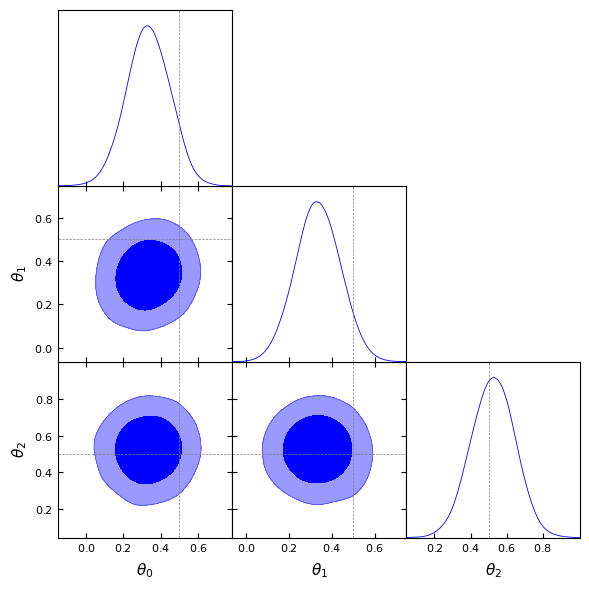

In [15]:
labels = [rf'\theta_{i}' for i in range(n_dim)]

samples_gd = MCSamples(samples=samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([samples_gd], filled=True,
                line_args=[
                    {'color': 'blue'}
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial[0])
                })

plt.show()

In [16]:
predictive_key, master_key = jax.random.split(master_key)
x_predictive = simulator(samples, predictive_key)

Removed no burn in


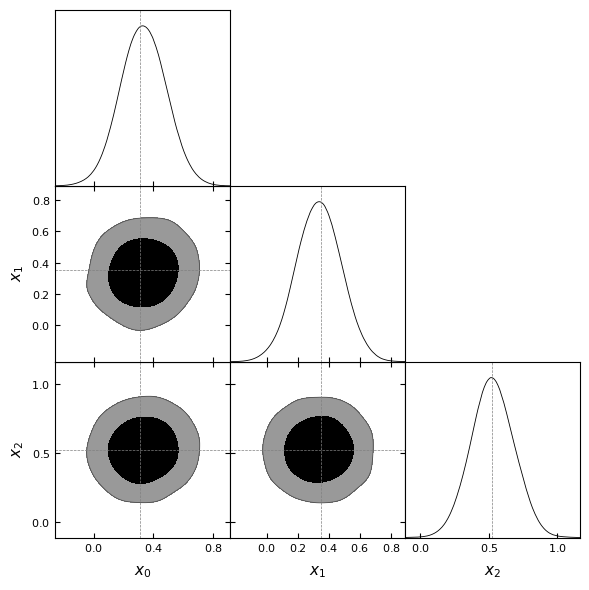

In [17]:
labels = [rf'x_{i}' for i in range(n_dim)]

predictive_samples_gd = MCSamples(samples=x_predictive, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([predictive_samples_gd], filled=True,
                line_args=[
                    {'color': 'black'}
                ],
                contour_colors=['black'],
                markers={
                    label: val for label, val in zip(labels, obs[0])
                })

plt.show()

In [18]:
test_set = inference._test_dataset

In [20]:
theta_test, x_test = test_set[:]

In [27]:
posterior.sample(num_samples, master_key, x=x_test)

TypeError: Cannot concatenate arrays with different numbers of dimensions: got (10000, 1), (10000, 1000, 3).

In [45]:
def sample(x):
    return posterior.sample(num_samples=1, key=master_key, x=x)

In [47]:
jax.vmap(sample)(x_test[:1000]).shape

(1000, 1, 3)